# Set-up

## Imports

In [40]:
import sys
import os
sys.path.append(os.path.abspath('..')) # for importing from python files not in the same directory

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.cm import plasma
import seaborn as sns
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy.stats import pearsonr, spearmanr

from utils import plot_components, month_to_season, functional_norm, normalize_curves

colors = sns.color_palette("deep")
sns.set_theme()
pd.options.mode.chained_assignment = None

## Parameters

In [2]:
n_comp = 5
n_runs = 1000
train_years = ['2021']
test_years = ['2022', '2023']

# arrays_path = f'data/3_output/nmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs.npz'
arrays_path = f"../data/3_output/pennmf_results/batch_clean/clean_results_{n_comp}comp_{n_runs}runs_{'_'.join(train_years)}.npz"
models_path = arrays_path.replace('.npz', '.pkl')

hue_order = {
    'daytype': ['Monday', 'Working day', 'Saturday', 'Holiday'],
    'season': ['Spring', 'Summer', 'Fall', 'Winter']
}

## Functions

# Main

## Deconvolve load and compute consumption per sectors

In [3]:
input_df = pd.read_csv(f"../data/2_processed/daily_curves_Italy.csv", index_col=0)
# Convert everything in GWh
input_df = input_df / 1000
pattern = r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$'
unit_info = input_df.index.str.extract(pattern).set_index(input_df.index)
unit_info['season'] = unit_info.month.astype(int).map(month_to_season)
df = pd.concat([input_df, unit_info], axis=1)
select_period_train = df.year.isin(train_years)
select_period_test = df.year.isin(test_years)
df = df.loc[select_period_train | select_period_test, :]
unit_info = unit_info.loc[select_period_train | select_period_test, :]
unit_info_train = unit_info.loc[select_period_train, :]
unit_info_test = unit_info.loc[select_period_test, :]
df_train = df.loc[select_period_train, :]
df_test = df.loc[select_period_test, :]
print(len(df_train))
df_train.head(3)

365


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,region,year,month,daytype,season
Italy_2021-01-01_Holiday,24.375000,23.142999,21.418001,20.136000,19.257999,19.473999,20.382000,21.137000,21.204001,22.809999,...,30.031000,28.681,27.158999,24.913000,22.807000,Italy,2021,01,Holiday,Winter
Italy_2021-01-02_Saturday,22.807000,21.146000,20.085000,19.431001,19.543000,20.095000,22.104000,23.960001,25.809999,28.031999,...,34.347000,31.864,29.392999,26.308999,23.326001,Italy,2021,01,Saturday,Winter
Italy_2021-01-03_Holiday,23.326001,21.322000,20.397999,19.543001,19.229000,19.879000,21.032999,22.168000,23.240000,25.000999,...,32.547001,30.280,28.256999,25.917000,23.235001,Italy,2021,01,Holiday,Winter


In [4]:
# Load the arrays from the .npz file
data = np.load(arrays_path)
with open(models_path, 'rb') as file:
    models = pickle.load(file)
# Access the arrays
S_results = data['S_results']
Ctrain_results = data['C_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint_c = data['loss_constraint_c']
loss_constraint_s = data['loss_constraint_s']

n_runs = S_results.shape[-1]

In [5]:
X_unnorm_train = df_train.drop(unit_info_train.columns, axis=1)
X_unnorm_test = df_test.drop(unit_info_test.columns, axis=1)
X_unnorm_train_test = pd.concat([X_unnorm_train, X_unnorm_test])

unit_info_train_test = pd.concat([unit_info_train, unit_info_test])

h = 24 / (X_unnorm_train_test.shape[1]-1)

norm_X_train_test = X_unnorm_train_test.apply(lambda row: functional_norm(row, h), axis=1, raw=True)
norm_X_train = norm_X_train_test[unit_info_train_test.year.isin(train_years)]
norm_X_test = norm_X_train_test[unit_info_train_test.year.isin(test_years)]

curves_comp = {}

X_test = df_test.drop(unit_info_test.columns, axis=1)
X_test = normalize_curves(X_test)

p = X_unnorm_train.shape[1]

# Matrix D for computing functional L^1-norm vectorised
D = np.ones(p)
D[0] = 0.5
D[-1] = 0.5
h = 24 / (p-1)
D = h * D

In [ ]:
# Adding the predicted concentrations to the fitted concentrations
Cpred_results = np.zeros((len(X_unnorm_test), n_comp, n_runs))

print(f"Estimating the sources concentrations in the test data for the {n_runs} runs...")
for run, model in enumerate(tqdm(models)):
    Cpred_results[..., run] = model.transform(X_test, random_state=42)
print("Done.")

print("Disaggregating the load per component...")
C_results = np.concatenate((Ctrain_results, Cpred_results), axis=0)
n_days = C_results.shape[0]
norms = norm_X_train_test.values.reshape(n_days, 1, 1, 1)
load = norms * C_results[..., np.newaxis, :] * np.stack([S_results] * n_days, axis=0)

# Here we reshape load so that we have run changing first, then, hour and finally unit
load = pd.DataFrame(load.transpose((0, 3, 2, 1)).reshape((n_days * n_runs * p, n_comp)), index=np.repeat(norm_X_train_test.index, n_runs * p), columns=[f'Component {k+1}' for k in range(n_comp)])
load['run'] = np.tile(np.repeat(np.arange(n_runs), p), n_days)
load['hour'] = np.tile(X_test.columns.astype(int), n_runs * n_days)
# Add the datetime
load['date_str'] = load.index.str[6:16]
load['date'] = pd.to_datetime(load['date_str'])
load['datetime'] = load['date'] + pd.to_timedelta(load['hour'], unit='h')
load = load.drop(columns=['date_str', 'date'])

load['Domestico'] = load['Component 1'] + load['Component 2']
load['Industria'] = load['Component 3']
load['Servizi'] = load['Component 4'] + load['Component 5']

print("Done.")

# Compute functional norm of each day for each run
print("Computing the sectors profiles by normalizing the disaggregated load...")
sectors = ['Domestico', 'Industria', 'Servizi']
norms = load.reset_index().groupby(['index', 'run'], as_index=False, sort=False)[sectors].agg(lambda a: a.dot(D))
profiles = load.drop([f'Component {k+1}' for k in range(n_comp)], axis=1)
profiles[sectors] = profiles[sectors] /  np.repeat(norms[sectors], repeats=p, axis=0)
profiles[unit_info.columns] = np.repeat(unit_info_train_test, repeats=p*n_runs, axis=0)
print("Done.")
profiles

Estimating the sources concentrations in the test data for the 231 runs...


100%|██████████| 231/231 [00:44<00:00,  5.23it/s]


Done.
Disaggregating the load per component...
Done.
Computing the sectors profiles by normalizing the disaggregated load...
Done.


,run,hour,datetime,Domestico,Industria,Servizi,region,year,month,daytype,season
Italy_2021-01-01_Holiday,0,0,2021-01-01 00:00:00,0.042878,0.029921,0.039942,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,1,2021-01-01 01:00:00,0.038762,0.028210,0.037627,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,2,2021-01-01 02:00:00,0.035911,0.027387,0.035994,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,3,2021-01-01 03:00:00,0.034467,0.027189,0.034789,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,4,2021-01-01 04:00:00,0.034164,0.027426,0.033872,Italy,2021,01,Holiday,Winter
...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,230,20,2023-12-31 20:00:00,0.048130,0.042618,0.050985,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,230,21,2023-12-31 21:00:00,0.048667,0.040138,0.045499,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,230,22,2023-12-31 22:00:00,0.044085,0.035878,0.044113,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,230,23,2023-12-31 23:00:00,0.040117,0.032787,0.040790,Italy,2023,12,Holiday,Fall


In [7]:
df_list = []
for b in tqdm(range(n_runs)):
    C = C_results[..., b]

    consumptions = (norm_X_train_test.to_numpy()[:, np.newaxis] * C)
    consumptions = pd.DataFrame(consumptions, columns=[f'Component {k + 1}' for k in range(n_comp)], index=X_unnorm_train_test.index)
    consumptions['date'] = consumptions.index.str.split('_').str[1]
    consumptions = pd.concat([consumptions, unit_info_train_test], axis=1)

    consumptions['run'] = b

    df_list.append(consumptions)

day_df = pd.concat(df_list).sort_values(['date', 'run']) # Sort to recover the time order
day_df

100%|██████████| 231/231 [00:00<00:00, 590.17it/s]


,Component 1,Component 2,Component 3,Component 4,Component 5,date,region,year,month,daytype,season,run
Italy_2021-01-01_Holiday,176.140453,89.929966,16.344301,236.223549,79.432232,2021-01-01,Italy,2021,01,Holiday,Winter,0
Italy_2021-01-01_Holiday,169.128477,94.131064,19.435223,228.926143,86.152585,2021-01-01,Italy,2021,01,Holiday,Winter,1
Italy_2021-01-01_Holiday,262.987607,74.001215,43.145577,86.918352,130.679968,2021-01-01,Italy,2021,01,Holiday,Winter,2
Italy_2021-01-01_Holiday,112.922791,147.098189,11.253872,217.374682,109.276108,2021-01-01,Italy,2021,01,Holiday,Winter,3
Italy_2021-01-01_Holiday,65.100839,223.792307,0.450731,122.379604,186.085263,2021-01-01,Italy,2021,01,Holiday,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,178.535874,51.288031,22.520632,98.211521,252.741789,2023-12-31,Italy,2023,12,Holiday,Fall,226
Italy_2023-12-31_Holiday,110.475540,100.944658,17.620155,143.727620,230.468293,2023-12-31,Italy,2023,12,Holiday,Fall,227
Italy_2023-12-31_Holiday,226.794535,108.954938,34.864478,23.873179,208.654736,2023-12-31,Italy,2023,12,Holiday,Fall,228
Italy_2023-12-31_Holiday,178.309396,31.250163,27.319704,45.822776,320.558768,2023-12-31,Italy,2023,12,Holiday,Fall,229


In [8]:
month_df = day_df.groupby(['region', 'year', 'month', 'run'], as_index=False, sort=False)[[f'Component {k+1}' for k in range(n_comp)]].sum()
month_df

,region,year,month,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,01,0,4081.379498,2962.140797,11970.783979,2755.514527,5323.470525
1,Italy,2021,01,1,3704.398528,3400.382580,11915.076474,2942.570019,5124.102137
2,Italy,2021,01,2,4654.238983,2378.584032,11953.928240,1431.955606,6674.653886
3,Italy,2021,01,3,3936.169716,3166.585287,11939.064218,2911.734854,5138.844826
4,Italy,2021,01,4,3085.109529,3982.256396,11941.315848,1505.166778,6581.122767
...,...,...,...,...,...,...,...,...,...
8311,Italy,2023,12,226,3238.128699,2705.469402,11087.758817,1998.552271,5786.569920
8312,Italy,2023,12,227,4508.941997,2290.854230,10420.097607,3348.274347,4247.520532
8313,Italy,2023,12,228,2884.847553,3486.603804,10372.041951,2481.395324,5592.387942
8314,Italy,2023,12,229,2788.074808,2968.515407,11341.415926,1731.889573,5986.530248


In [9]:
year_df = month_df.groupby(['region', 'year', 'run'], as_index=False)[[f'Component {k+1}' for k in range(n_comp)]].sum()
year_df

,region,year,run,Component 1,Component 2,Component 3,Component 4,Component 5
0,Italy,2021,0,33254.151065,37854.453521,150338.108496,47353.737471,49494.606018
1,Italy,2021,1,36258.670609,34809.957234,150335.909165,52735.607542,44141.355854
2,Italy,2021,2,38133.171868,32954.030614,150276.568930,47099.288910,49848.019524
3,Italy,2021,3,30682.521275,40398.575969,150327.888802,47358.854727,49522.443808
4,Italy,2021,4,32955.344240,38184.748038,150288.885527,47778.997262,49101.410220
...,...,...,...,...,...,...,...,...
688,Italy,2023,226,35925.915965,29732.589067,151404.797479,46472.322213,44412.301742
689,Italy,2023,227,36710.778151,35131.970538,148308.576136,42799.459357,45022.611989
690,Italy,2023,228,31583.408622,34483.382931,144639.518608,52942.163674,44325.770870
691,Italy,2023,229,33733.194289,32146.024244,151250.099538,44845.051741,45982.748515


In [10]:
# Y_train = pd.read_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(train_years)))
# Y_test = pd.read_pickle('data/2_processed/PenNMF/Y_{}.pkl'.format('_'.join(test_years)))
# Y = pd.concat([Y_train, Y_test], axis=0).sort_index()
Y = pd.read_pickle('../data/2_processed/PenNMF/Y.pkl')
Y

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,6578.069013,12076.214575,8758.839428
2020-02-01,5527.985114,12490.529300,7644.235592
2020-03-01,6397.951558,10704.954781,6622.130700
2020-04-01,5700.031442,8660.806370,5383.390680
2020-05-01,4977.937414,11658.651789,6011.084788
2020-06-01,4910.926859,11869.539002,7233.085663
2020-07-01,6107.741032,13094.183037,9521.393403
2020-08-01,7009.210582,8879.384386,9913.436574
2020-09-01,5157.447797,12777.718546,8433.093670


In [11]:
Y_pred = month_df.copy()
Y_pred['Domestico'] = Y_pred['Component 1'] + Y_pred['Component 2']
Y_pred['Industria'] = Y_pred['Component 3']
Y_pred['Servizi'] = Y_pred['Component 4'] + Y_pred['Component 5']
Y_pred.drop(columns=[f'Component {k+1}' for k in range(n_comp)], inplace=True)
Y_pred = Y_pred.groupby(['year', 'month', 'run'], as_index=False).sum().drop('region', axis=1)
Y_pred['date'] = pd.to_datetime(Y_pred['year'].astype(str) + '-' + Y_pred['month'], format='%Y-%m')
Y_pred.drop(columns=['year', 'month'], inplace=True)
# Set the 'date' column as the index
Y_pred.set_index('date', inplace=True)
Y_pred

,run,Domestico,Industria,Servizi
date,,,,
2021-01-01,0,7043.520295,11970.783979,8078.985052
2021-01-01,1,7104.781108,11915.076474,8066.672156
2021-01-01,2,7032.823015,11953.928240,8106.609492
2021-01-01,3,7102.755004,11939.064218,8050.579680
2021-01-01,4,7067.365926,11941.315848,8086.289546
...,...,...,...,...
2023-12-01,226,5943.598102,11087.758817,7785.122191
2023-12-01,227,6799.796227,10420.097607,7595.794879
2023-12-01,228,6371.451358,10372.041951,8073.783266


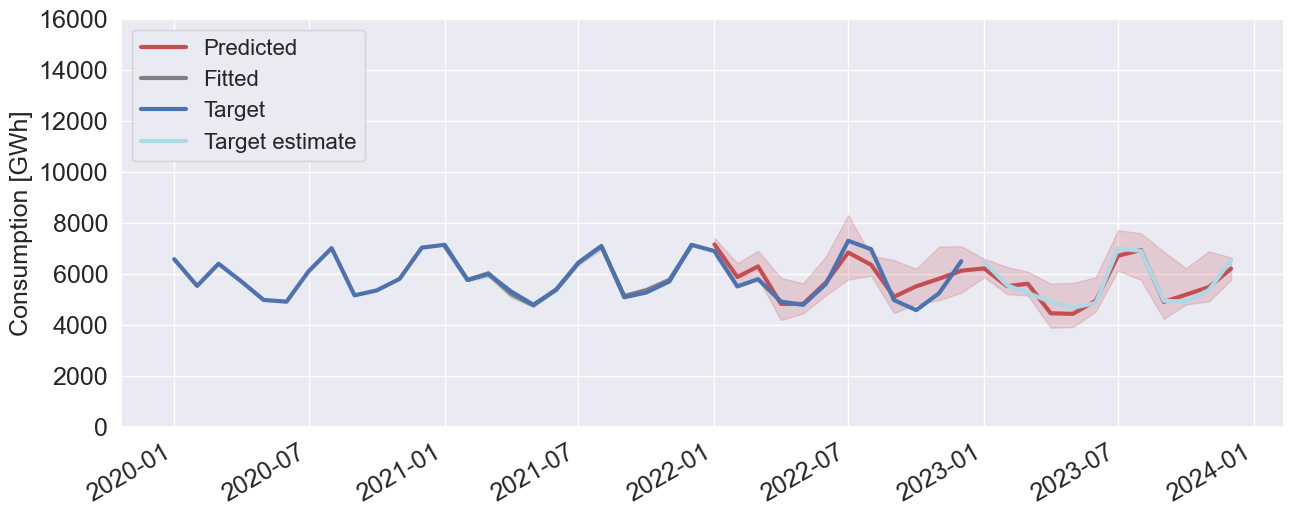

In [12]:
# Define the sector to plot
sector = 'Domestico'
linewidth = 3

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    # marker='o',
    linewidth=linewidth
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    # marker='o',
    linewidth=linewidth
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(color=colors[0], label='Target', ax=ax, linewidth=linewidth)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(color='lightblue', label='Target estimate', ax=ax, linewidth=linewidth)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')

fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

# Add the legend
ax.legend(fontsize=fontsize-2, loc='upper left')

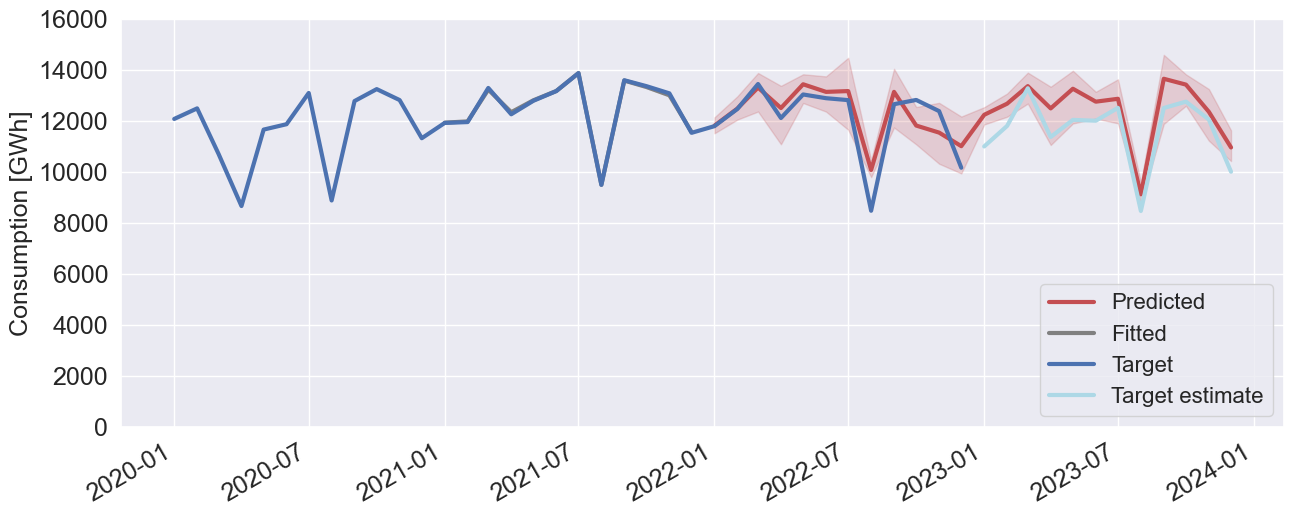

In [13]:
# Define the sector to plot
sector = 'Industria'
linewidth = 3

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    # marker='o',
    linewidth=linewidth
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    # marker='o',
    linewidth=linewidth
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(color=colors[0], label='Target', ax=ax, linewidth=linewidth)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(color='lightblue', label='Target estimate', ax=ax, linewidth=linewidth)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')

fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

# Add the legend
ax.legend(fontsize=fontsize-2, loc='lower right')

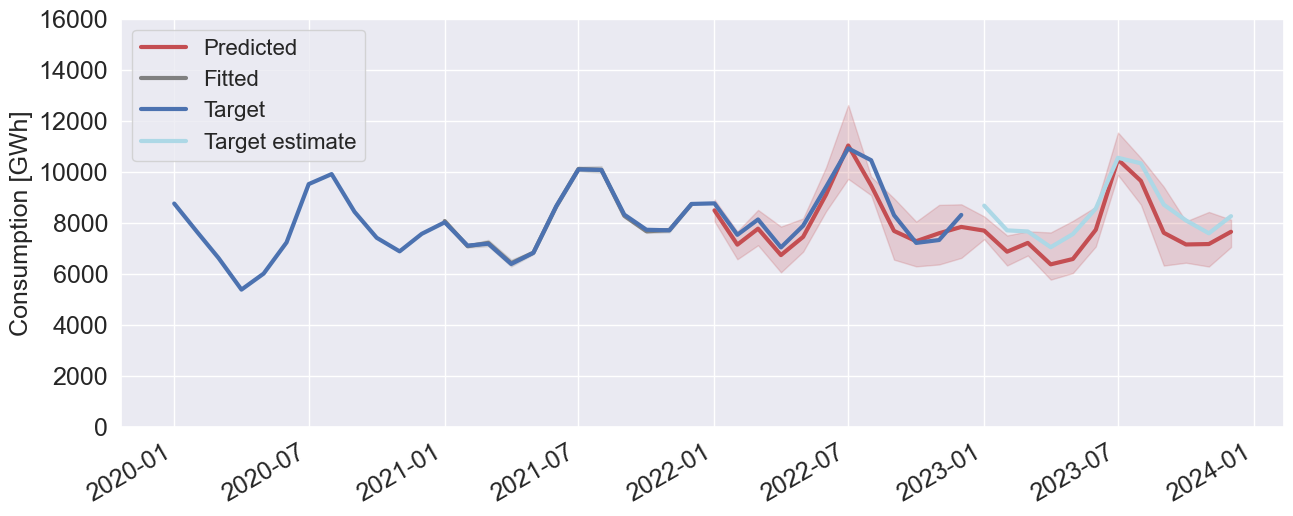

In [14]:
# Define the sector to plot
sector = 'Servizi'
linewidth = 3

# Create a matplotlib figure and axis
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(test_years)].reset_index(),
    x='date',
    y=sector,
    color=colors[3],
    label='Predicted',
    errorbar='pi',
    ax=ax,
    # marker='o',
    linewidth=linewidth
)

sns.lineplot(
    data=Y_pred[Y_pred.index.year.astype(str).isin(train_years)].reset_index(),
    x='date',
    y=sector,
    color='grey',
    label='Fitted',
    errorbar='pi',
    ax=ax,
    # marker='o',
    linewidth=linewidth
)

# Plot the target data using pandas' plot method
Y.loc[Y.index.year < 2023, sector].plot(color=colors[0], label='Target', ax=ax, linewidth=linewidth)
# Plot the target data using pandas' plot method
Y.loc[Y.index.year == 2023, sector].plot(color='lightblue', label='Target estimate', ax=ax, linewidth=linewidth)

# Customize the plot
ax.set_ylim((0, 16000))
ax.set_ylabel('Consumption [GWh]')

fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

# Add the legend
ax.legend(fontsize=fontsize-2, loc='upper left')

In [15]:
Y_pred.to_pickle('../data/3_output/month_pred/double_constraint/Y_pred_train_{}_test_{}.pkl'.format('_'.join(train_years), '_'.join(test_years)))

In [16]:
Y_pred

,run,Domestico,Industria,Servizi
date,,,,
2021-01-01,0,7043.520295,11970.783979,8078.985052
2021-01-01,1,7104.781108,11915.076474,8066.672156
2021-01-01,2,7032.823015,11953.928240,8106.609492
2021-01-01,3,7102.755004,11939.064218,8050.579680
2021-01-01,4,7067.365926,11941.315848,8086.289546
...,...,...,...,...
2023-12-01,226,5943.598102,11087.758817,7785.122191
2023-12-01,227,6799.796227,10420.097607,7595.794879
2023-12-01,228,6371.451358,10372.041951,8073.783266


In [17]:
Y_pred.groupby(Y_pred.index)[sectors].mean().to_excel('../data/3_output/month_pred/double_constraint/monthly_cons_train_{}_test_{}.xlsx'.format('_'.join(train_years), '_'.join(test_years)))

In [18]:
Y.to_excel('../data/3_output/month_pred/double_constraint/monthly_cons_true.xlsx'.format('_'.join(train_years), '_'.join(test_years)))

### Error assessment on indicators and annual consumption data

In [19]:
Y_hat = Y_pred.groupby(Y_pred.index)[sectors].mean()
Y_hat

,Domestico,Industria,Servizi
date,,,
2021-01-01,7085.140331,11930.877721,8072.881516
2021-02-01,5758.704795,11980.413521,7085.259256
2021-03-01,6023.995773,13228.667354,7214.770283
2021-04-01,5201.915056,12340.248383,6418.046697
2021-05-01,4765.614595,12807.829080,6832.515458
2021-06-01,5393.644613,13172.662134,8646.299579
2021-07-01,6423.929355,13874.220522,10114.999419
2021-08-01,7081.214476,9496.500159,10082.199468
2021-09-01,5135.625595,13580.941250,8277.258692


In [27]:
yoy_pred = Y_hat.pct_change(periods=12) * 100
yoy_pred

,Domestico,Industria,Servizi
date,,,
2021-01-01,NaN,NaN,NaN
2021-02-01,NaN,NaN,NaN
2021-03-01,NaN,NaN,NaN
2021-04-01,NaN,NaN,NaN
2021-05-01,NaN,NaN,NaN
2021-06-01,NaN,NaN,NaN
2021-07-01,NaN,NaN,NaN
2021-08-01,NaN,NaN,NaN
2021-09-01,NaN,NaN,NaN


In [75]:
# Read true indicators
# indics = pd.read_csv('../data/1_input/indicators/indicators.csv', index_col=0, parse_dates=True)
indics = Y
yoy_true = indics.pct_change(periods=12) * 100
yoy_true

,Domestico,Industria,Servizi
Mese,,,
2020-01-01,NaN,NaN,NaN
2020-02-01,NaN,NaN,NaN
2020-03-01,NaN,NaN,NaN
2020-04-01,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN
2020-07-01,NaN,NaN,NaN
2020-08-01,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN


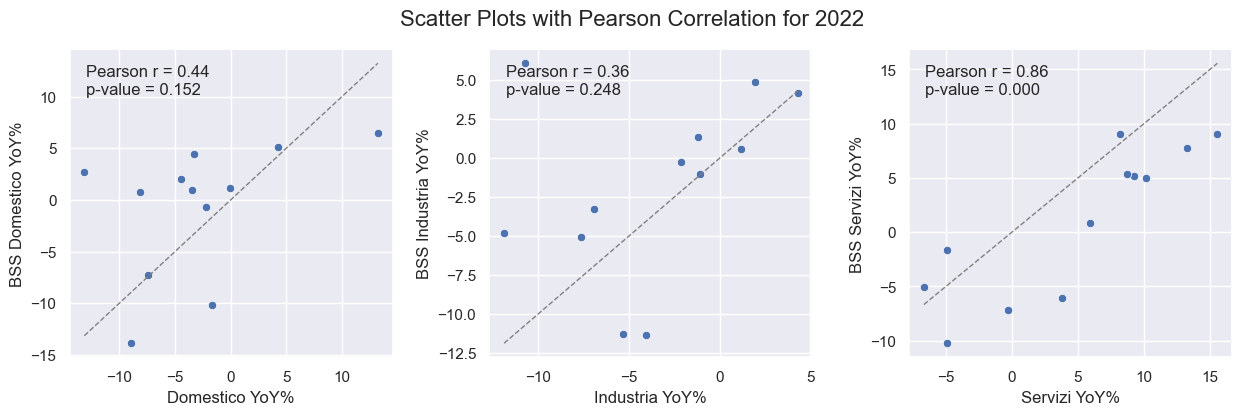

In [77]:
year = 2022
# indics = ['EnelDom', 'IMCEI', 'IMSER']
indics = sectors
correlation = 'Pearson'

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, sector in enumerate(sectors):

    x = yoy_true.loc[yoy_true.index.year == year, indics[i]]
    y = yoy_pred.loc[yoy_pred.index.year == year, sector]

    # Calculate correlation and p-value
    if correlation == 'Spearman':
        corr, p_value = spearmanr(x, y)
    else:
        corr, p_value = pearsonr(x, y)

    sns.scatterplot(x=x, y=y, ax=axs[i])

    axs[i].plot([x.min(), x.max()], [x.min(), x.max()], color='grey', linestyle='--', linewidth=1, label="y = x")

    # Display correlation and p-value on the plot
    axs[i].text(0.05, 0.95, f'{correlation} r = {corr:.2f}\np-value = {p_value:.3f}', 
                fontsize=12, ha='left', va='top', transform=axs[i].transAxes)

    # Customize the plot
    # axs[i].set_title(f"Scatter Plot with Pearson Correlation for {year}")
    axs[i].set_xlabel(f"{indics[i]} YoY%")
    axs[i].set_ylabel(f"BSS {sector} YoY%")

# Set a common title for all subplots
fig.suptitle(f"Scatter Plots with {correlation} Correlation for {year}", fontsize=16)

# Adjust the layout
plt.subplots_adjust(wspace=0.3, hspace=0.2) 

In [70]:
test_years

['2022', '2023']

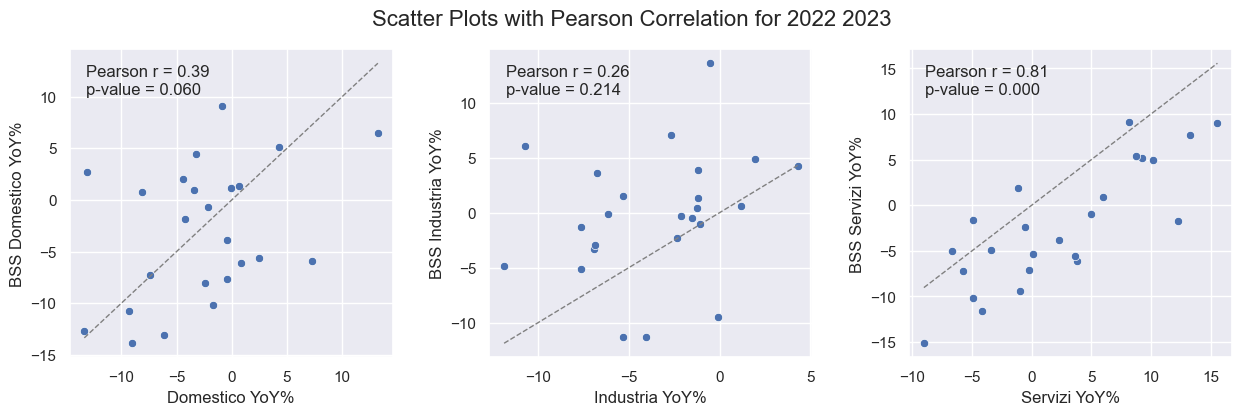

In [78]:
# indics = ['EnelDom', 'IMCEI', 'IMSER']

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i, sector in enumerate(sectors):

    x = yoy_true.loc[yoy_true.index.year.astype(str).isin(test_years), indics[i]]
    y = yoy_pred.loc[yoy_pred.index.year.astype(str).isin(test_years), sector]

    # Calculate Pearson correlation and p-value
    corr, p_value = pearsonr(x, y)

    sns.scatterplot(x=x, y=y, ax=axs[i])

    axs[i].plot([x.min(), x.max()], [x.min(), x.max()], color='grey', linestyle='--', linewidth=1, label="y = x")

    # Display correlation and p-value on the plot
    axs[i].text(0.05, 0.95, f'Pearson r = {corr:.2f}\np-value = {p_value:.3f}', 
                fontsize=12, ha='left', va='top', transform=axs[i].transAxes)

    # Customize the plot
    # axs[i].set_title(f"Scatter Plot with Pearson Correlation for {year}")
    axs[i].set_xlabel(f"{indics[i]} YoY%")
    axs[i].set_ylabel(f"BSS {sector} YoY%")

# Set a common title for all subplots
fig.suptitle(f"Scatter Plots with Pearson Correlation for {' '.join(test_years)}", fontsize=16)

# Adjust the layout
plt.subplots_adjust(wspace=0.3, hspace=0.2) 

## Retrieve sectors profiles

In [15]:
profiles

,run,hour,datetime,Domestico,Industria,Servizi,region,year,month,daytype,season
Italy_2021-01-01_Holiday,0,0,2021-01-01 00:00:00,0.038520,0.024586,0.040607,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,1,2021-01-01 01:00:00,0.035306,0.023068,0.037793,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,2,2021-01-01 02:00:00,0.033218,0.022667,0.035808,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,3,2021-01-01 03:00:00,0.032289,0.022750,0.034488,Italy,2021,01,Holiday,Winter
Italy_2021-01-01_Holiday,0,4,2021-01-01 04:00:00,0.032192,0.023340,0.033779,Italy,2021,01,Holiday,Winter
...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,158,20,2023-12-31 20:00:00,0.055458,0.043712,0.044220,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,21,2023-12-31 21:00:00,0.049886,0.041589,0.043279,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,22,2023-12-31 22:00:00,0.043838,0.037180,0.042942,Italy,2023,12,Holiday,Fall
Italy_2023-12-31_Holiday,158,23,2023-12-31 23:00:00,0.038229,0.034045,0.041054,Italy,2023,12,Holiday,Fall


In [16]:
profiles_ens = profiles.reset_index().groupby(unit_info.columns.to_list() + ['run', 'hour'], as_index=False, sort=False)[sectors].mean()
profiles_ens

,region,year,month,daytype,season,run,hour,Domestico,Industria,Servizi
0,Italy,2021,01,Holiday,Winter,0,0,0.032227,0.024586,0.041028
1,Italy,2021,01,Holiday,Winter,0,1,0.029197,0.023068,0.038148
2,Italy,2021,01,Holiday,Winter,0,2,0.027424,0.022667,0.036198
3,Italy,2021,01,Holiday,Winter,0,3,0.026765,0.022750,0.034961
4,Italy,2021,01,Holiday,Winter,0,4,0.027099,0.023340,0.034318
...,...,...,...,...,...,...,...,...,...,...
572395,Italy,2023,12,Monday,Fall,158,20,0.056148,0.043712,0.048166
572396,Italy,2023,12,Monday,Fall,158,21,0.049345,0.041589,0.045918
572397,Italy,2023,12,Monday,Fall,158,22,0.042814,0.037180,0.044314
572398,Italy,2023,12,Monday,Fall,158,23,0.036967,0.034045,0.041654


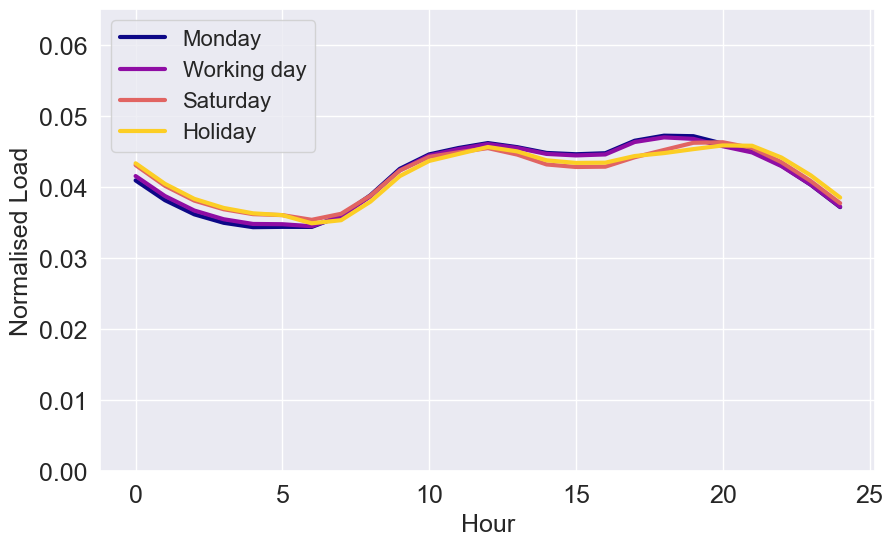

In [28]:
sector = 'Servizi'
hue = 'daytype'

palette = {
    'season': ['#77dd77', '#ffdb58', '#FF8C00', '#4682B4'],
    'daytype': [plasma(value) for value in np.linspace(0, 0.9, 4)]
}

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=profiles_ens.groupby([hue, 'hour', 'run'], as_index=False)[sector].mean(),
    x='hour',
    y=sector,
    errorbar=None,
    ax=ax,
    hue=hue,
    hue_order=hue_order[hue],
    # marker='o',
    linewidth=3,
    palette=palette[hue]
)
# Set a title for the plot
# ax.set_title(f'Profile for sector {sector}', fontsize=16)
ax.set_ylim((0,0.065))
ax.set_ylabel('Normalised Load', fontsize=fontsize)
ax.legend(title=None, loc='upper left', fontsize=fontsize-2)
ax.set_xlabel('Hour', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
plt.show()

## Visualise disaggregated consumption

### Hourly

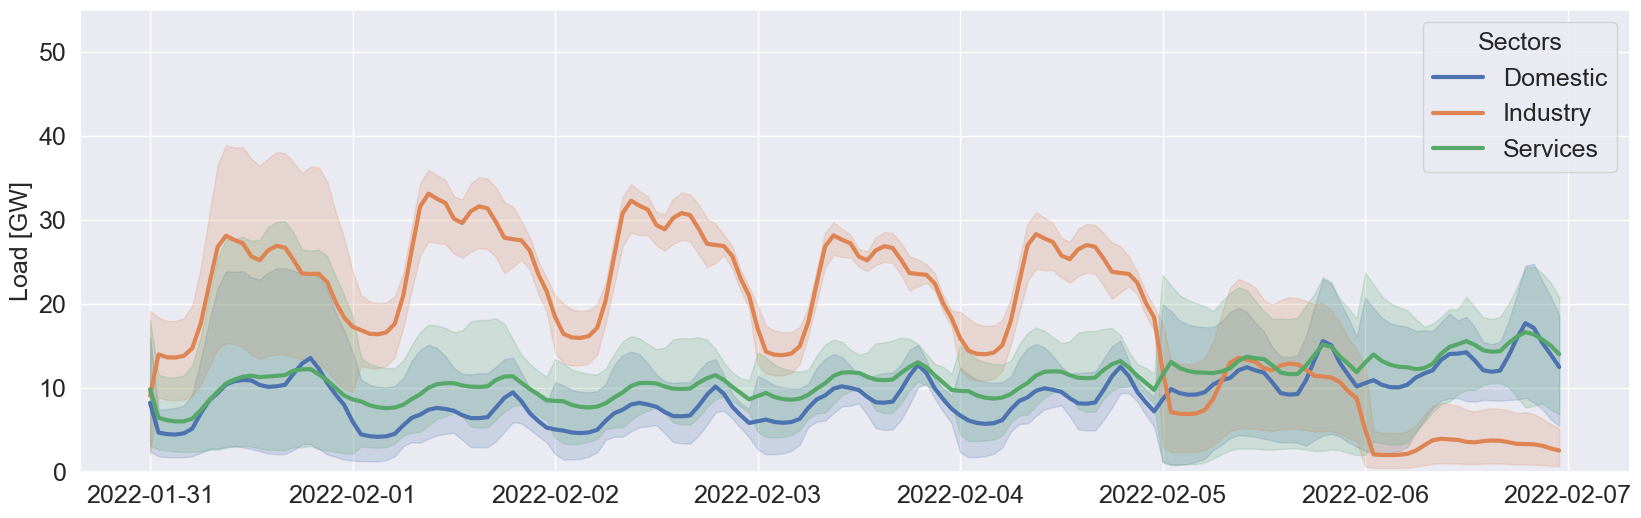

In [28]:
# period = ["2022-11-01", "2022-11-15"]
period = ["2022-01-31 00:00:00", "2022-02-06 23:59:00"]
sector = 'Domestico'
fig, ax = plt.subplots(figsize=(20, 6))
linewidth = 3
sns.lineplot(
    data=load[(load.datetime >= period[0]) & (load.datetime <= period[1])],
    x='datetime',
    y=sector,
    color=colors[0],
    errorbar='pi',
    ax=ax,
    marker='',
    label='Domestic',
    linewidth=linewidth
)

sns.lineplot(
    data=load[(load.datetime >= period[0]) & (load.datetime <= period[1])],
    x='datetime',
    y='Industria',
    color=colors[1],
    errorbar='pi',
    ax=ax,
    marker='',
    label='Industry',
    linewidth=linewidth
)

sns.lineplot(
    data=load[(load.datetime >= period[0]) & (load.datetime <= period[1])],
    x='datetime',
    y='Servizi',
    color=colors[2],
    errorbar='pi',
    ax=ax,
    marker='',
    label='Services',
    linewidth=linewidth
)

plt.ylim(top=55, bottom=0)

fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Load [GW]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

# Add the legend
ax.legend(title='Sectors', fontsize=fontsize, title_fontsize=fontsize)

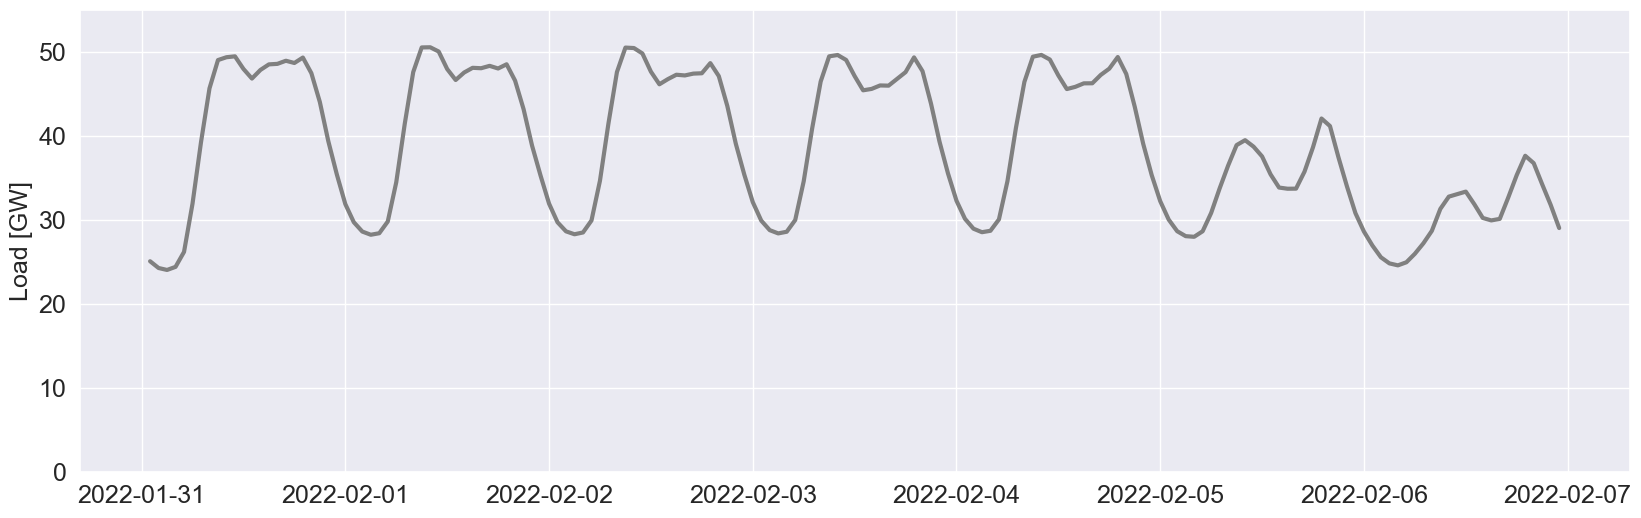

In [29]:
period = ["2022-01-31 00:00:00", "2022-02-06 23:59:00"]
fig, ax = plt.subplots(figsize=(20, 6))
plot_df = load[(load.datetime > period[0]) & (load.datetime < period[1])]
plot_df['Total load'] = plot_df['Domestico'] + plot_df['Industria'] + plot_df['Servizi']
sns.lineplot(
    data=plot_df,
    x='datetime',
    y='Total load',
    color='grey',
    errorbar=None,
    ax=ax,
    marker='',
    linewidth=3
)
plt.ylim(bottom=0, top=55)
# Customize font sizes
fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Load [GW]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

### Daily

In [30]:
day_df

,Component 1,Component 2,Component 3,Component 4,Component 5,date,region,year,month,daytype,season,run
Italy_2021-01-01_Holiday,176.140453,89.929966,16.344301,236.223549,79.432232,2021-01-01,Italy,2021,01,Holiday,Winter,0
Italy_2021-01-01_Holiday,169.128477,94.131064,19.435223,228.926143,86.152585,2021-01-01,Italy,2021,01,Holiday,Winter,1
Italy_2021-01-01_Holiday,262.987607,74.001215,43.145577,86.918352,130.679968,2021-01-01,Italy,2021,01,Holiday,Winter,2
Italy_2021-01-01_Holiday,112.922791,147.098189,11.253872,217.374682,109.276108,2021-01-01,Italy,2021,01,Holiday,Winter,3
Italy_2021-01-01_Holiday,65.100839,223.792307,0.450731,122.379604,186.085263,2021-01-01,Italy,2021,01,Holiday,Winter,4
...,...,...,...,...,...,...,...,...,...,...,...,...
Italy_2023-12-31_Holiday,178.145758,50.848663,23.805456,98.092952,252.419284,2023-12-31,Italy,2023,12,Holiday,Fall,226
Italy_2023-12-31_Holiday,108.567865,100.168746,21.371212,143.967660,229.173007,2023-12-31,Italy,2023,12,Holiday,Fall,227
Italy_2023-12-31_Holiday,227.030570,109.335740,33.087919,23.859516,209.827970,2023-12-31,Italy,2023,12,Holiday,Fall,228
Italy_2023-12-31_Holiday,178.192896,31.142112,27.703612,45.811012,320.415241,2023-12-31,Italy,2023,12,Holiday,Fall,229


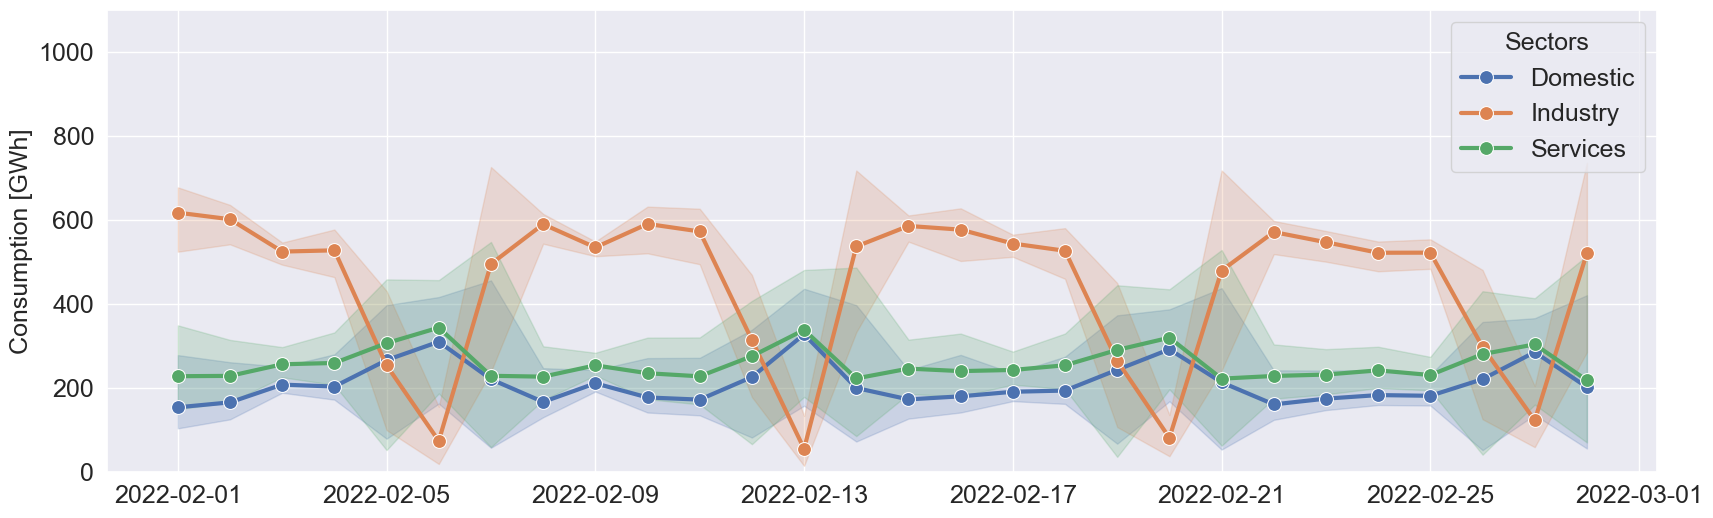

In [31]:
# Filter data for the specified period
period = ["2022-02-01", "2022-02-28"]
filtered_data = day_df[(day_df.date >= period[0]) & (day_df.date <= period[1])]
filtered_data['Domestic'] = filtered_data['Component 1'] + filtered_data['Component 2']
filtered_data['Industry'] = filtered_data['Component 3']
filtered_data['Services'] = filtered_data['Component 4'] + filtered_data['Component 5']

# Reshape the data using pandas.melt
melted_data = pd.melt(
    filtered_data,
    id_vars=['date'],  # Keep datetime as the identifier
    value_vars=['Domestic', 'Industry', 'Services'],  # Columns to melt
    var_name='Sector',  # New column for sectors
    value_name='Consumption'  # New column for load values
)
melted_data['date'] = pd.to_datetime(melted_data['date'])

# Create the plot in a single lineplot call
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(
    data=melted_data,
    x='date',
    y='Consumption',
    hue='Sector',  # Differentiate the lines by the sector
    palette=[colors[0], colors[1], colors[2]],  # Use the same color mapping
    errorbar='pi',
    ax=ax,
    linewidth=3,
    marker='o',
    markersize=10
)

# Set y-limit
plt.ylim(top=1100, bottom=0)

# Customize the font sizes
fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

# Add the legend
ax.legend(title='Sectors', fontsize=fontsize, title_fontsize=fontsize)

plt.show()

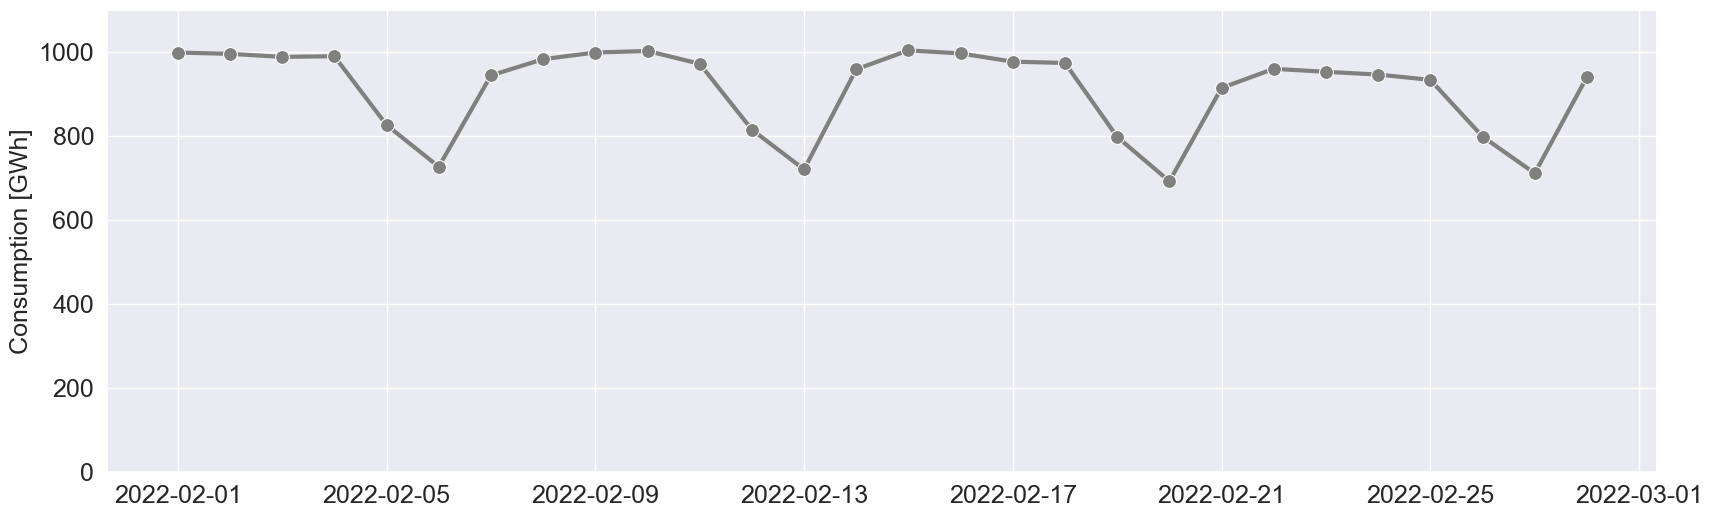

In [32]:
filtered_data['Total'] = filtered_data['Domestic'] + filtered_data['Industry'] + filtered_data['Services']
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Create the plot in a single lineplot call
fig, ax = plt.subplots(figsize=(20, 6))
sns.lineplot(
    data=filtered_data,
    x='date',
    y='Total',
    color='grey',  # Use the same color mapping
    errorbar=None,
    ax=ax,
    linewidth=3,
    marker='o',
    markersize=10
)

# Set y-limit
plt.ylim(top=1100, bottom=0)

# Customize the font sizes
fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Consumption [GWh]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize

plt.show()

<HR>

# TESTS

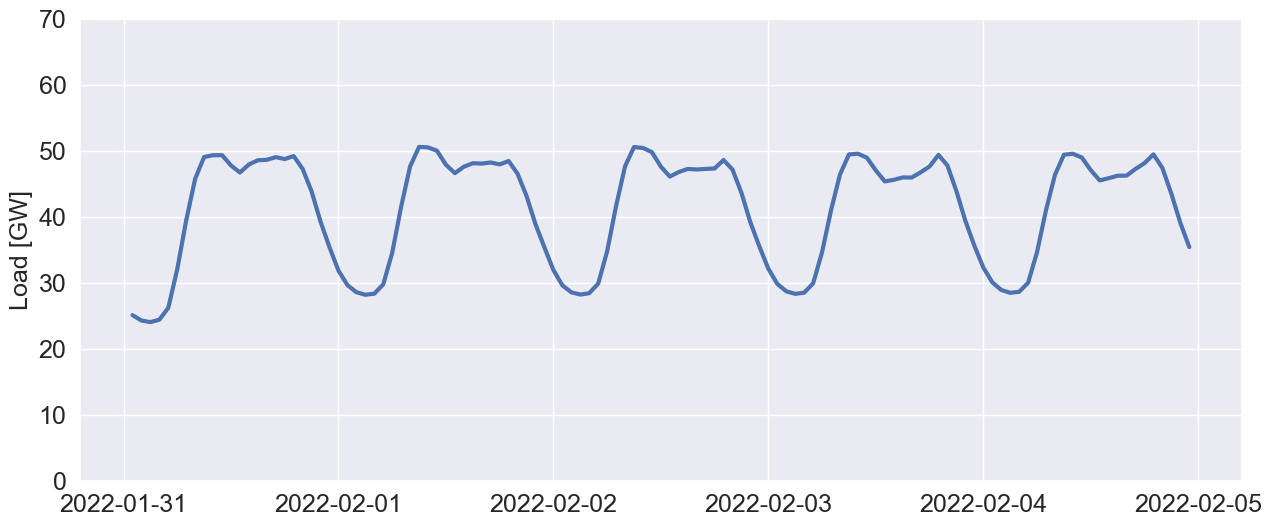

In [ ]:
period = ["2022-01-31 00:00:00", "2022-02-04 23:59:00"]
fig, ax = plt.subplots(figsize=(15, 6))
plot_df = load[(load.datetime > period[0]) & (load.datetime < period[1])]
plot_df = plot_df.groupby('datetime', as_index=False)[sectors].mean()
plot_df['Total load'] = plot_df['Domestico'] + plot_df['Industria'] + plot_df['Servizi'] # + np.random.normal(0, 5, size=len(plot_df))
sns.lineplot(
    data=plot_df,
    x='datetime',
    y='Total load',
    # color='grey',
    errorbar=None,
    ax=ax,
    marker='',
    linewidth=3
)
plt.ylim(bottom=0, top=70)
# Customize font sizes
fontsize = 18
ax.set_xlabel(None, fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel("Load [GW]", fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize